In [ ]:
! pip install pykrx

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
import pandas as pd
import numpy as np
from pykrx import stock
import matplotlib.pyplot as plt
from datetime import datetime
import datetime

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16,6
plt.rc('font', family='NanumBarunGothic') 

## 1. 매출서프라이즈 비율

#### data

In [ ]:
def get_data(data_name):
  data_path = '/content/drive/MyDrive/프로젝트/어닝/data/final data/'
  data = pd.read_csv(data_path + data_name + '.csv', header=[0,1], index_col=[0,1])
  data = data.reset_index(1).rename(columns={'level_1':'name'})

  # 데이터 str to float
  for col in data.columns[1:]: 
    data[col] = data[col].apply(lambda x: float(x.replace(',','')) if type(x)==str else x)
  #id에서 A제거
  data.index = [id.replace('A','') for id in data.index]
  return data

In [ ]:
sales_year = get_data('sales_year')
sales_quarter = get_data('sales_quarter')
con_year = get_data('con_year')
con_quarter = get_data('con_quarter')

매출서프라이즈 비율 지수 산출

In [ ]:
sales_surprise_2018 = (sales_year[('2018','매출액')] - con_year[('2018', '매출액')])*100/con_year[('2018', '매출액')]

In [ ]:
sales_surprise_2018 = sales_surprise_2018.dropna()

In [ ]:
rank_per = sales_surprise_2018.rank(ascending=False)/len(sales_surprise_2018) #랭크
surprise_group = sales_surprise_2018[rank_per <= 0.2].sort_values(ascending=False)
shock_group = sales_surprise_2018[rank_per >= 0.8].sort_values()

KOSPI

In [ ]:
#KOSPI 상위 200개 종목의 2018년 시가 데이터프레임 생성
market_calender = pd.date_range('2018-01-01', '2018-12-31', freq='B')

start_date = str(20180101)
end_date = str(20181231)
ticker_list = list(surprise_group.index.values) #서프라이즈 그룹 id

price_df = pd.DataFrame(columns=ticker_list, index=market_calender)

for ticker in ticker_list:
    df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)['시가']
    price_df[ticker] = df

price_df.dropna(how='all', inplace=True)
price_df = price_df.T

In [ ]:
#코스피200종목명 리스트
name_list = []
kospi200 = stock.get_index_portfolio_deposit_file("1028") #코스피200종목 리스트
for ticker in kospi200:
        name = stock.get_market_ticker_name(ticker)
        name_list.append(name)
name_list.remove('DL이앤씨') 

기업 공시 데이터

In [ ]:
#잠정공시>매출액변경공시>사업보고서
#최초보고서 데이터 
first = pd.read_csv('/content/drive/MyDrive/프로젝트/어닝/data/final data/최초보고서.csv', index_col=0, parse_dates=name_list) 
#기재 정정(잠정)
equipment = pd.read_csv('/content/drive/MyDrive/프로젝트/어닝/data/final data/기재정정.csv', index_col=0, parse_dates=name_list) 
#영업실적(잠정)
performance = pd.read_csv('/content/drive/MyDrive/프로젝트/어닝/data/final data/영업실적.csv', index_col=0, parse_dates=name_list) 
#매출액변경공시 
revenue = pd.read_csv('/content/drive/MyDrive/프로젝트/어닝/data/final data/매출액변경.csv', index_col=0, parse_dates=name_list) 

In [ ]:
#기업 딕셔너리 (key:id, value:name)
company_dic = con_year['name'].to_dict() #key:id, value:name
#company_dic = {name: id for id, name in company_dic.items()}

#### 매출서프라이즈 비율 (2018)
- 매출 서프라이즈 비율: 매출액 컨센서스 대비 실제 발표치의 변화 정도
- 그룹 
  - 어닝 서프라이즈 그룹: 판단 지표를 기준으로 상위 20% 종목군
  - 어닝 쇼크 그룹: 하위 20% 그룹 

- 주가 기준: 코스피 지수 수익률을 차감한 상대 주가 (논의)
  - 강세장/양세장인지에 따른 절대 주가 영향도 중립화

- 분석 방법
  - KOSPI200 종목을 유니버스로 삼아, 각 어닝 시즌별로 서프라이즈 상위 20% 종목군을 롱하고, 쇼크 상위 20% 종목군을 숏함 
  - 실적발표일의 익영업일 시가를 기준으로 어닝 서프라이즈 그룹과 쇼크 그룹의 +30영업일, 직전 -10영업일 주가 추이 분석
  - 수익률 측정: 상위 20%종목의 동일비중 투자수익률에서 하위 20% 종목의 동일비중 투자수익률을 뺀 수치

#### 어닝 서프라이즈

- 어닝서프라이즈 (매출서프라이즈 비율 1위)

In [ ]:
dates = first[company_dic[surprise_group.index[0]]]
equipment_dates = equipment[company_dic[surprise_group.index[0]]]
performance_dates = performance[company_dic[surprise_group.index[0]]]
revenue_dates = revenue[company_dic[surprise_group.index[0]]]
#dates[0].date() #날짜만 가져옴

Text(2018-11-14 00:00:00, 140000, '2018-11-14')

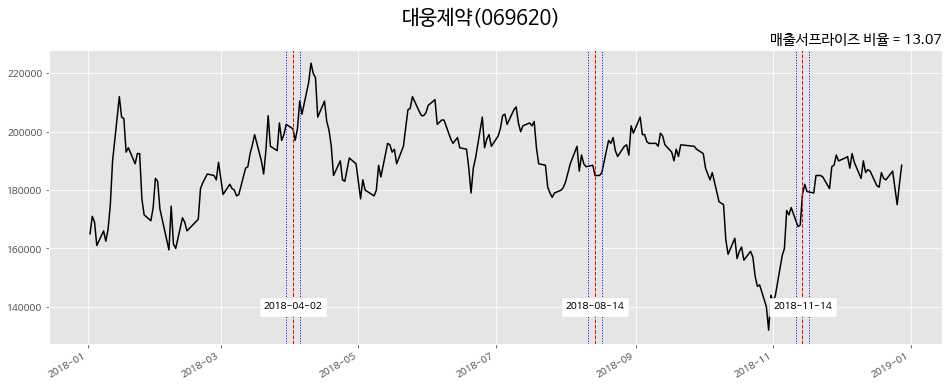

In [ ]:
#+- 3일
price_df.loc[surprise_group.index[0]].plot(color='black')
plt.suptitle(company_dic[surprise_group.index[0]]+'('+surprise_group.index[0]+')', fontsize=20)
plt.title('매출서프라이즈 비율 = {}'.format(round(surprise_group[0], 2)), loc='right')

plt.axvline(dates[0], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[0]+datetime.timedelta(days=-3), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[0]+datetime.timedelta(days=3), color='blue', linestyle=':', linewidth='1')
plt.text(dates[0], 140000, dates[0].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[1], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[1]+datetime.timedelta(days=-3), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[1]+datetime.timedelta(days=3), color='blue', linestyle=':', linewidth='1')
plt.text(dates[1], 140000, dates[1].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[2], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[2]+datetime.timedelta(days=-3), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[2]+datetime.timedelta(days=3), color='blue', linestyle=':', linewidth='1')
plt.text(dates[2], 140000, dates[2].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

Text(2018-11-14 00:00:00, 140000, '2018-11-14')

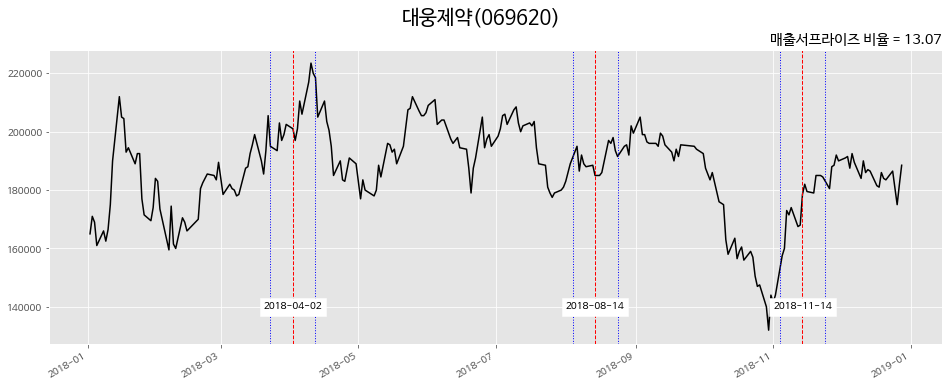

In [ ]:
#+- 10일
price_df.loc[surprise_group.index[0]].plot(color='black')
plt.suptitle(company_dic[surprise_group.index[0]]+'('+surprise_group.index[0]+')', fontsize=20)
plt.title('매출서프라이즈 비율 = {}'.format(round(surprise_group[0], 2)), loc='right')

plt.axvline(dates[0], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[0]+datetime.timedelta(days=-10), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[0]+datetime.timedelta(days=10), color='blue', linestyle=':', linewidth='1')
plt.text(dates[0], 140000, dates[0].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[1], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[1]+datetime.timedelta(days=-10), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[1]+datetime.timedelta(days=10), color='blue', linestyle=':', linewidth='1')
plt.text(dates[1], 140000, dates[1].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[2], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[2]+datetime.timedelta(days=-10), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[2]+datetime.timedelta(days=10), color='blue', linestyle=':', linewidth='1')
plt.text(dates[2], 140000, dates[2].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

Text(2018-11-14 00:00:00, 160000, '2018-11-14')

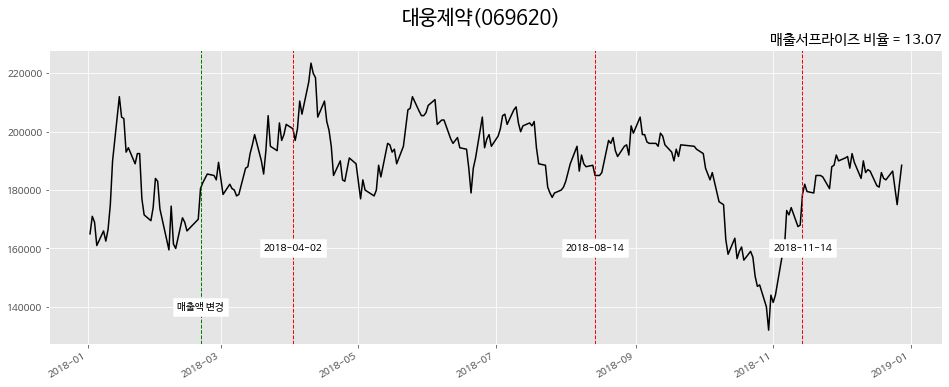

In [ ]:
#공시별 비교
price_df.loc[surprise_group.index[0]].plot(color='black')
plt.suptitle(company_dic[surprise_group.index[0]]+'('+surprise_group.index[0]+')', fontsize=20)
plt.title('매출서프라이즈 비율 = {}'.format(round(surprise_group[0], 2)), loc='right')

#매출액 변경
plt.axvline(revenue_dates[0], color='green', linestyle='--', linewidth='1')
plt.text(revenue_dates[0], 140000, '매출액 변경', ha='center', va='center',rotation='horizontal', backgroundcolor='white')

#최초 날짜
plt.axvline(dates[0], color='red', linestyle='--', linewidth='1')
plt.text(dates[0], 160000, dates[0].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[1], color='red', linestyle='--', linewidth='1')
plt.text(dates[1], 160000, dates[1].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[2], color='red', linestyle='--', linewidth='1')
plt.text(dates[2], 160000, dates[2].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')


- 어닝서프라이즈 (매출서프라이즈 비율 2위)

In [ ]:
dates = first[company_dic[surprise_group.index[1]]]
equipment_dates = equipment[company_dic[surprise_group.index[1]]]
performance_dates = performance[company_dic[surprise_group.index[1]]]
revenue_dates = revenue[company_dic[surprise_group.index[1]]]
#dates[0].date() #날짜만 가져옴

In [ ]:
revenue_dates

0   2018-02-09
1   2019-02-12
2          NaT
3          NaT
Name: 한전기술, dtype: datetime64[ns]

Text(2018-11-14 00:00:00, 30000, '2018-11-14')

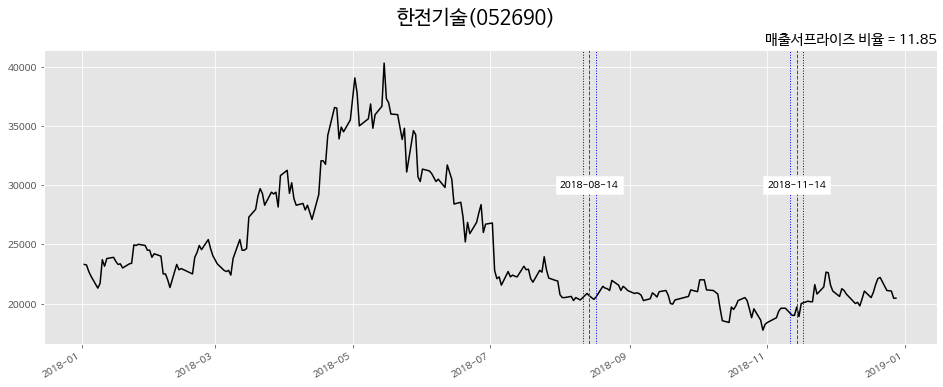

In [ ]:
#+- 3일
price_df.loc[surprise_group.index[1]].plot(color='black')
plt.suptitle(company_dic[surprise_group.index[1]]+'('+surprise_group.index[1]+')', fontsize=20)
plt.title('매출서프라이즈 비율 = {}'.format(round(surprise_group[1], 2)), loc='right')

plt.axvline(dates[0], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[0]+datetime.timedelta(days=-3), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[0]+datetime.timedelta(days=3), color='blue', linestyle=':', linewidth='1')
plt.text(dates[0], 30000, dates[0].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[1], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[1]+datetime.timedelta(days=-3), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[1]+datetime.timedelta(days=3), color='blue', linestyle=':', linewidth='1')
plt.text(dates[1], 30000, dates[1].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

Text(2018-11-14 00:00:00, 30000, '2018-11-14')

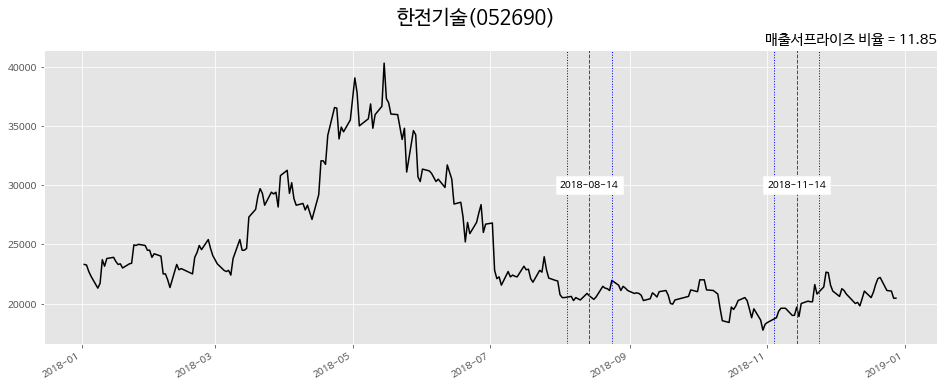

In [ ]:
#+- 10일
price_df.loc[surprise_group.index[1]].plot(color='black')
plt.suptitle(company_dic[surprise_group.index[1]]+'('+surprise_group.index[1]+')', fontsize=20)
plt.title('매출서프라이즈 비율 = {}'.format(round(surprise_group[1], 2)), loc='right')

plt.axvline(dates[0], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[0]+datetime.timedelta(days=-10), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[0]+datetime.timedelta(days=10), color='blue', linestyle=':', linewidth='1')
plt.text(dates[0], 30000, dates[0].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[1], color='red', linestyle='--', linewidth='1')
plt.axvline(dates[1]+datetime.timedelta(days=-10), color='blue', linestyle=':', linewidth='1')
plt.axvline(dates[1]+datetime.timedelta(days=10), color='blue', linestyle=':', linewidth='1')
plt.text(dates[1], 30000, dates[1].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

Text(2018-11-14 00:00:00, 30000, '2018-11-14')

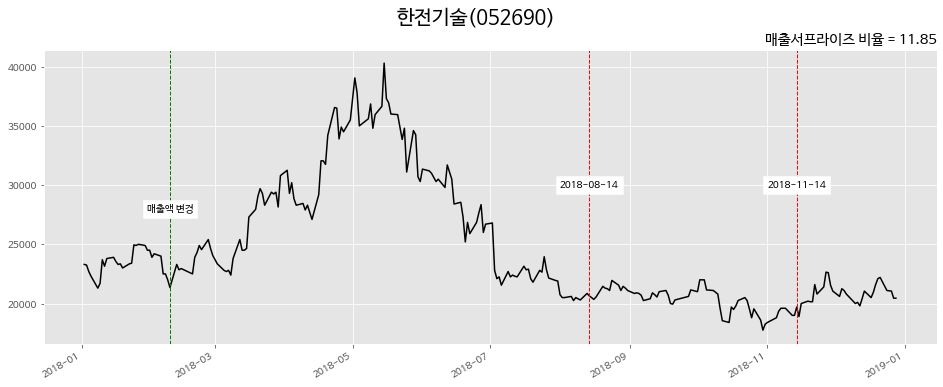

In [ ]:
#공시별 비교 
price_df.loc[surprise_group.index[1]].plot(color='black')
plt.suptitle(company_dic[surprise_group.index[1]]+'('+surprise_group.index[1]+')', fontsize=20)
plt.title('매출서프라이즈 비율 = {}'.format(round(surprise_group[1], 2)), loc='right')

#매출액 변경
plt.axvline(revenue_dates[0], color='green', linestyle='--', linewidth='1')
plt.text(revenue_dates[0], 28000, '매출액 변경', ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[0], color='red', linestyle='--', linewidth='1')
plt.text(dates[0], 30000, dates[0].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.axvline(dates[1], color='red', linestyle='--', linewidth='1')
plt.text(dates[1], 30000, dates[1].date(), ha='center', va='center',rotation='horizontal', backgroundcolor='white')

# 아이디어
- 서프라이즈 그룹간 공분산은 어떤지, 리스크 관리는 할 수 있는지
- 만약 관련이 있다면 어떤 비율로 넣을건지도(최적화)